<a href="https://colab.research.google.com/github/MASSIMOQSELLA/MyAKarpathyMicrogradTest/blob/main/Sigla_NP_Zhang.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Drive già montato.
Original data shape: (42000, 785)
Train set> data: (29400, 784), labels: (29400, 1), True: 2881, False: 26519 
Test set> data: (12600, 784), labels: (12600, 1), True: 1256, False: 11344 
Epoch 0/500, Loss: 0.6366073895174986, lr: 0.5, delta_loss: 0
Epoch 10/500, Loss: 0.29826301497069413, lr: 0.49977505773886427, delta_loss: -0.007625968287237772
Epoch 20/500, Loss: 0.21466736420912486, lr: 0.49905096355547374, delta_loss: -0.00861985636089882
 last d_l_ratio: -0.040052682531719855 is > best_d_l_ratio of last period: -0.7812512785742232 => reverting lr to: 0.49999500004999947)
Epoch 30/500, Loss: 0.15150842423539446, lr: 0.4988714177436074, delta_loss: -0.004846206606228198
Epoch 40/500, Loss: 0.11962306458094382, lr: 0.4971535746993587, delta_loss: -0.0025256346895617815
 last d_l_ratio: -0.019940731801422584 is > best_d_l_ratio of last period: -0.04176990895391785 => reverting lr to: 0.499890023145139)
Epoch 50/500, Loss: 0.1013845106675063, lr: 0.4978700177854798,

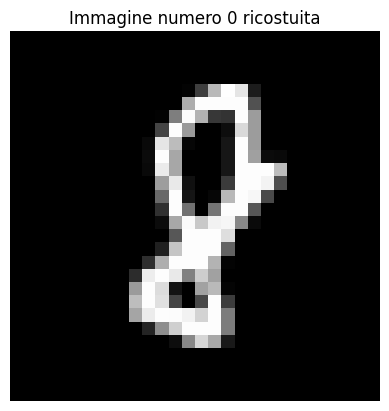

Prediction 1: [0.01447943] vs label [0]


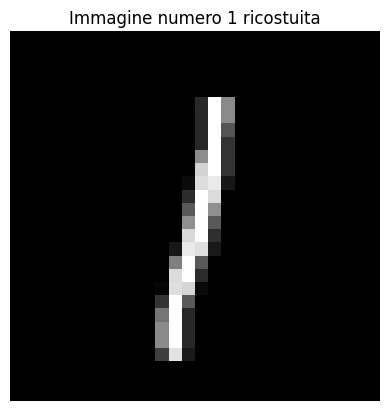

Prediction 2: [0.00057048] vs label [0]


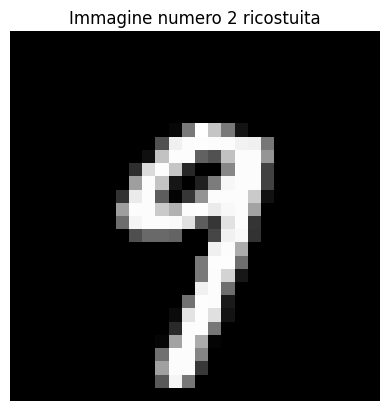

Prediction 3: [0.00051378] vs label [0]


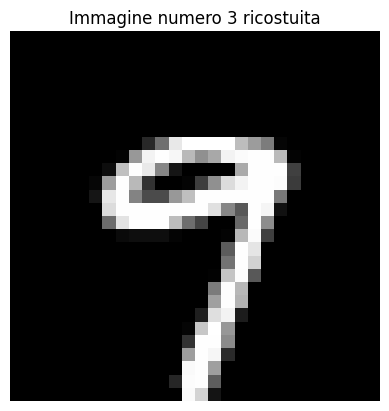

Prediction 4: [0.00084194] vs label [0]


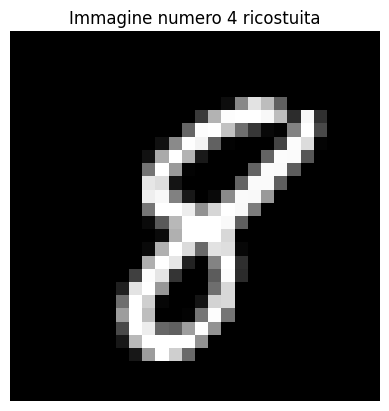

Prediction 5: [0.12714324] vs label [1]


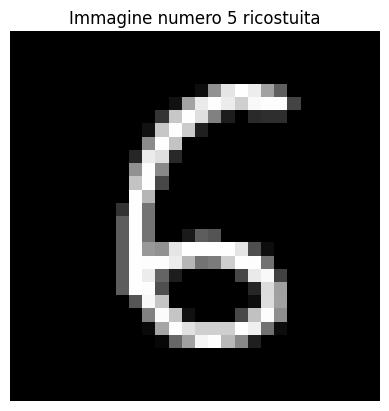

Prediction 6: [0.00046456] vs label [0]


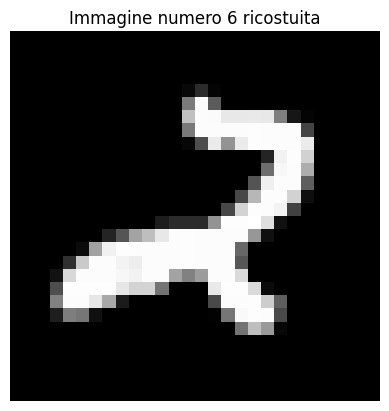

Prediction 7: [0.01088963] vs label [0]


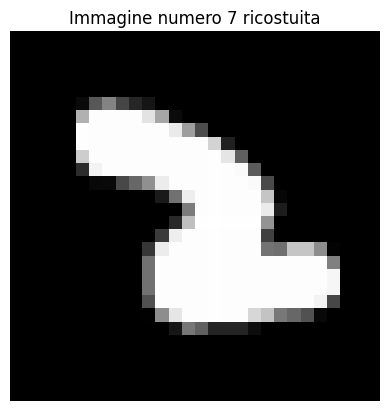

Prediction 8: [6.57484338e-06] vs label [0]


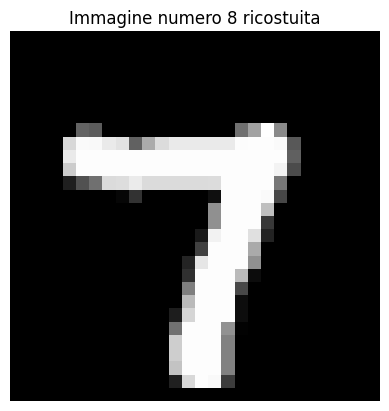

Prediction 9: [0.01367614] vs label [0]


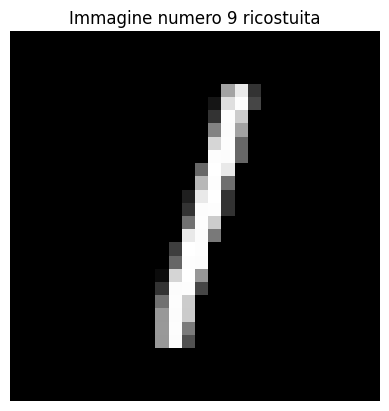

Prediction 10: [0.81295837] vs label [1]


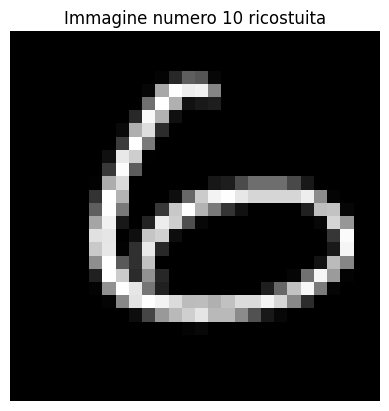

Prediction 11: [0.00041319] vs label [0]


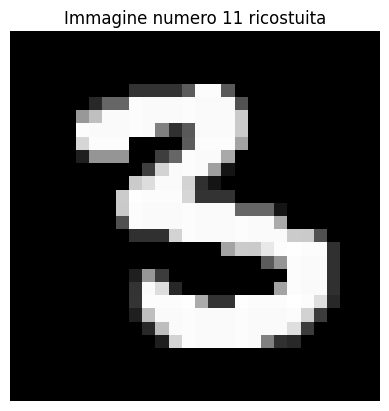

Prediction 12: [0.12480428] vs label [0]


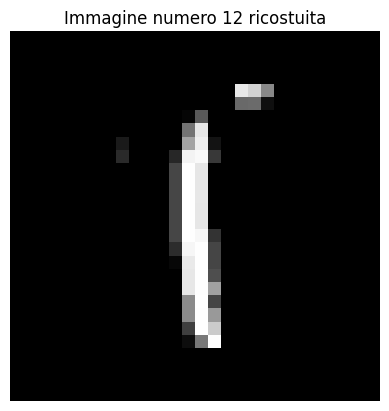

Prediction 13: [0.00214178] vs label [0]


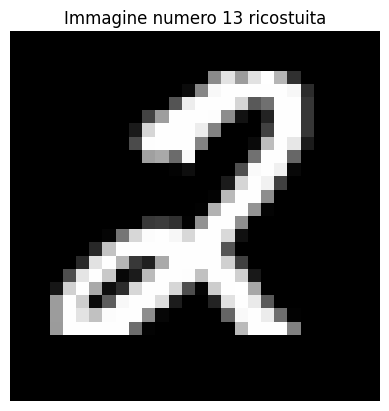

Prediction 14: [3.82776268e-05] vs label [0]


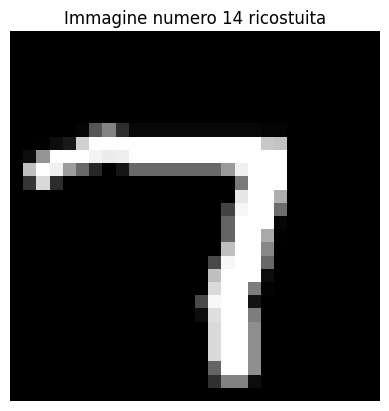

Prediction 15: [0.32617994] vs label [0]


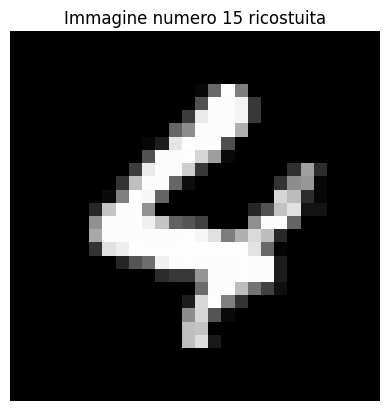

Prediction 16: [0.00037847] vs label [0]


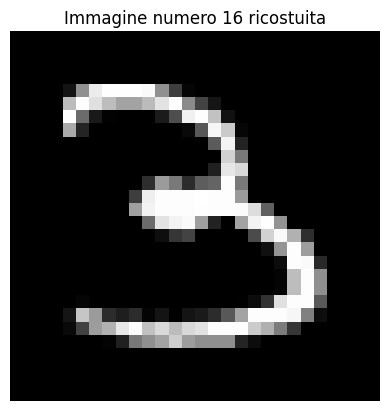

Prediction 17: [0.0062046] vs label [0]


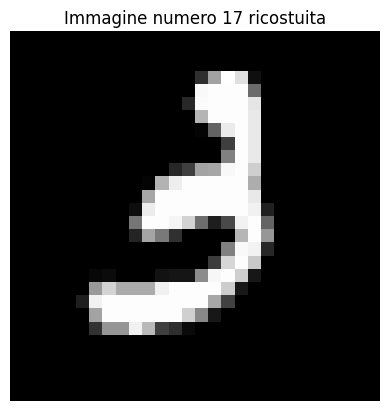

Prediction 18: [0.87789538] vs label [1]


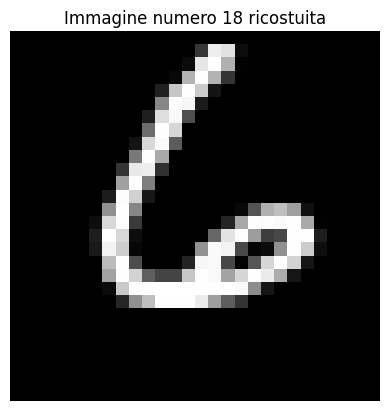

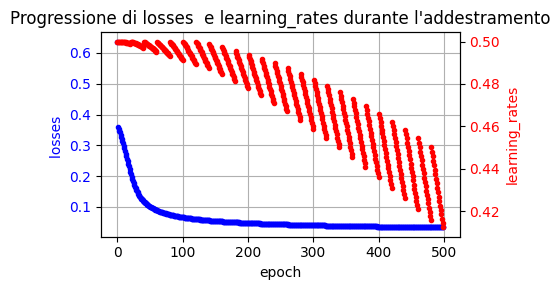

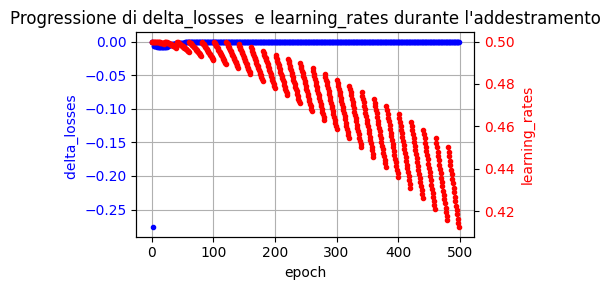

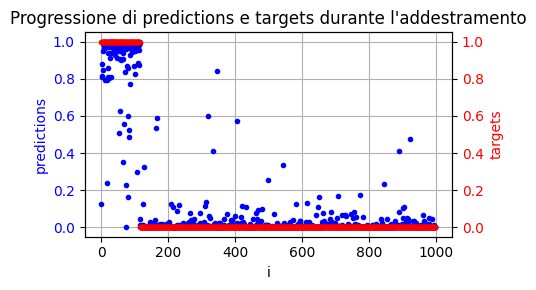

In [52]:
import numpy as np
import pandas as pd
import os
import sys
import matplotlib.pyplot as plt
import sys
from sklearn.model_selection import train_test_split
import time
from datetime import datetime
import logging
from google.colab import drive
from copy import deepcopy

# Configurazione del file di log
logging.basicConfig(
    filename='app.log',      # Nome del file di log
    level=logging.DEBUG,     # Livello di log (DEBUG per messaggi dettagliati)
    format='%(asctime)s - %(levelname)s - %(message)s'
)

#!git clone https://github.com/MASSIMOQSELLA/MyAKarpathyMicrogradTest.git

def input_set(data_vectors_path): # carica i dati di input dal repository e li restituisce per la elaborazione


  # Caricamento dei dati
  try:

    #RICORDA: inserisci i comandi per fare lo split dell'unico data set preso dal file di train

    data_vectors_orig = pd.read_csv(data_vectors_path)
    print(f"Original data shape: {data_vectors_orig.shape}")

    # fa una copia
    data_vectors = data_vectors_orig.copy();

    #binarizzare le etichette, 1 solo sul digit 6, zero sugli altri
    data_vectors.iloc[:, 0] = (data_vectors.iloc[:, 0] == 6).astype(int)

    X_data = data_vectors.iloc[:, 1:].values / 255.0  # Prende le colonne dalla seconda in poi (immagini) e le normalizza a [0-1]
    assert np.all((X_data >= 0) & (X_data <= 1)), "Dati non normalizzati correttamente!"
    y_data = data_vectors.iloc[:, 0].to_numpy().reshape(-1, 1)  # Prendi la prima colonna (etichette)

    # Suddividi il train set (esempio: 80% training, 20% validation)
    X_train, X_test, y_train, y_test = train_test_split(
    X_data, y_data, test_size=0.5, random_state=42)

    # conteggio false vs vere all'interno del train_set e del test_set
    train_false_num = np.count_nonzero(y_train == 0)
    train_real_num = np.count_nonzero(y_train == 1)
    test_false_num = np.count_nonzero(y_test == 0)
    test_real_num = np.count_nonzero(y_test == 1)
    print(f"Train set> data: {X_train.shape}, labels: {y_train.shape}, True: {train_real_num}, False: {train_false_num} ")
    print(f"Test set> data: {X_test.shape}, labels: {y_test.shape}, True: {test_real_num}, False: {test_false_num} ")

  except Exception as e:
    logging.error(f"An error occurred during data set processing with input_set : {e}")
    raise

  return X_train, X_test, y_train, y_test

class SimpleNN:

    def __init__(self, input_size, hidden_size1, hidden_size2, output_size):
        self.input_size = input_size
        self.hidden_size1 = hidden_size1
        self.hidden_size2 = hidden_size2
        self.output_size = output_size
        # Inizializza i pesi e i bias con He per ReLU
        #layer 1
        self.W1 = np.random.randn(input_size, hidden_size1) * np.sqrt(2. / input_size)
        self.b1 = np.random.randn(1, hidden_size1) * 0.01  # Piccoli valori casuali
        #layer 2
        self.W2 = np.random.randn(hidden_size1, hidden_size2) * np.sqrt(2. / hidden_size1)
        self.b2 = np.random.randn(1, hidden_size2) * 0.01
        #output layer
        self.W3 = np.random.randn(hidden_size2, output_size) * np.sqrt(2. / hidden_size2)
        self.b3 = np.random.randn(1, output_size) * 0.01


    def params(self):
        #Restituisce i parametri (pesi e bias) del modello come un dizionario
        return {
            'W1': self.W1, 'b1': self.b1,
            'W2': self.W2, 'b2': self.b2,
            'W3': self.W3, 'b3': self.b3
        }

    def relu(self, Z):
        return np.maximum(0, Z)

    def relu_derivative(self, Z):
      return Z > 0  # Restituisce un array booleano (True/False) che diventa 1/0

    def sigmoid(self, Z):
        return 1 / (1 + np.exp(-Z))

    def sigmoid_derivative(self, Z):
        return self.sigmoid(Z) * (1 - self.sigmoid(Z))

    def forward(self, X):
        # Passo forward
        # layer 1
        self.Z1 = np.dot(X, self.W1) + self.b1
        self.A1 = self.relu(self.Z1)
        # layer 2
        self.Z2 = np.dot(self.A1, self.W2) + self.b2
        self.A2 = self.relu(self.Z2)
        # output layer
        self.Z3 = np.dot(self.A2, self.W3) + self.b3
        self.A3 = self.sigmoid(self.Z3)

        return self.A3

    def compute_loss(self, X, y):
        #Calcola la funzione di loss utilizzando la Binary Cross-Entropy (BCE)
        predictions = self.forward(X)

        # Aggiungi un epsilon per evitare log(0) e garantire stabilità numerica
        epsilon = 1e-10
        predictions = np.clip(predictions, epsilon, 1 - epsilon)  # Restringi i valori tra [epsilon, 1 - epsilon]

        # Calcola la BCE
        loss = -np.mean(y * np.log(predictions) + (1 - y) * np.log(1 - predictions))

        return float(loss)

    def backward(self, X, y):

        # Calcolare l'errore (output - vero valore)
        m = X.shape[0]  # Numero di esempi nel batch


        # output layer gradients
        dA3 = self.A3 - y
        dZ3 = dA3 * self.sigmoid_derivative(self.Z3)
        dW3 = np.dot(self.A2.T, dZ3) / m
        db3 = np.sum(dZ3, axis=0, keepdims=True) / m

        # Layer 2 gradients
        dA2 = np.dot(dZ3, self.W3.T)
        dZ2 = dA2 * self.relu_derivative(self.Z2)
        dW2 = np.dot(self.A1.T, dZ2) / m
        db2 = np.sum(dZ2, axis=0, keepdims=True) / m

        # Layer 1 gradients
        dA1 = np.dot(dZ2, self.W2.T)
        dZ1 = dA1 * self.relu_derivative(self.Z1)
        dW1 = np.dot(X.T, dZ1) / m
        db1 = np.sum(dZ1, axis=0, keepdims=True) / m

        return {
            'W1': dW1, 'b1': db1,
            'W2': dW2, 'b2': db2,
            'W3': dW3, 'b3': db3
        }

#learning rate modulation based on an input representing the delta_loss between an iteration and another

def lr_adjustment(delta_loss, adj_magnitude = 0, offset = 0, non_linear = True):
  lr_adj = 0
  if non_linear:
    if (delta_loss >= 1000*offset): lr_adj =  adj_magnitude*np.tanh(10 * delta_loss)
    elif (-offset <= delta_loss < 0): lr_adj = adj_magnitude*np.tanh(1/(5* delta_loss))
  else:
    if (delta_loss >= 1000*offset): lr_adj = adj_magnitude;
    elif (-offset <= delta_loss < 0): lr_adj = -adj_magnitude
  return lr_adj

def time_based_decay(self, initial_learning_rate, decay_rate, epoch):
    self.initial_learning_rate = initial_learning_rate
    self.decay_rate = decay_rate
    self.epoch = epoch
    learning_rate = self.initial_learning_rate / (1 + self.decay_rate * self.epoch)
    return learning_rate

      # colleziona i dati


class my_data_collection:

  def __init__(self):
    self._data = []

  def collect_data(self, *args):
    self._data.append(tuple(
        np.copy(arg) if isinstance(arg, np.ndarray) else deepcopy(arg)
        for arg in args
    ))

  def __repr__(self):
        # Aggiunge un metodo di rappresentazione per debug e analisi dei dati.
        return f"my_data_collection(data={self._data})"

def train(model, X_train, y_train, initial_learning_rate, decay_rate, d_h, epochs=1000, reshuffle_int = 200):

     current_learning_rate = initial_learning_rate
     lr_adj = 0
     delta_loss = 0
     for epoch in range(epochs):

        #------faccio il primo step di apprendimento aggiornando i gradienti in base a loss e learning rate attuali

        # Calcolare la perdita
        loss = model.compute_loss(X_train, y_train)

        # Passo indietro (backward pass)
        gradients = model.backward(X_train, y_train)

        # Aggiorna i pesi e i bias con il gradiente discendente
        model.W1 -= current_learning_rate * gradients['W1']
        model.b1 -= current_learning_rate * gradients['b1']
        model.W2 -= current_learning_rate * gradients['W2']
        model.b2 -= current_learning_rate * gradients['b2']
        model.W3 -= current_learning_rate * gradients['W3']
        model.b3 -= current_learning_rate * gradients['b3']

        # stampo i dati correnti
        if (epoch == 0) or (epoch % 10 == 0):
          print(f"Epoch {epoch}/{epochs}, Loss: {loss}, lr: {current_learning_rate}, delta_loss: {delta_loss}")

        #storicizzo i dati correnti
        d_h.collect_data(epoch, loss, current_learning_rate, delta_loss)

        #------- calcolo il prossimo learning rate da applicare e decido se fare il reshuffle degli input

        #calcolare la differenza con la perdita del periodo precedente
        if (epoch != 0):
          delta_loss = (d_h._data[epoch][1] - d_h._data[epoch-1][1])

          # modifica continua del tasso di apprendimento in base al time decay
          lr_td = time_based_decay(model, current_learning_rate, decay_rate, epoch)
          current_learning_rate = lr_td

          # Modifica periodica del tasso di apprendimento in base alla variazione della perdita
          if (epoch % 20 == 0):

            last_delta_losses_ratio = [d_h._data[i][3]/d_h._data[i][1] for i in range(-20, 0)]
            best_delta_loss_ratio = min(last_delta_losses_ratio)  # Trova il valore minimo
            best_index = last_delta_losses_ratio.index(best_delta_loss_ratio)  # Trova l'indice del valore minimo
            last_l_rates =  [d_h._data[i][2] for i in range(-20, 0)]
            best_l_r = last_l_rates[best_index]
            delta_loss_ratio = delta_loss/loss
            if delta_loss_ratio <= best_delta_loss_ratio:
              print(f" last d_l_ratio: {delta_loss_ratio} is < best_d_l_ratio of last period: {best_delta_loss_ratio} => keep decaying lr: {lr_td})")
              pass
            else:
              print(f" last d_l_ratio: {delta_loss_ratio} is > best_d_l_ratio of last period: {best_delta_loss_ratio} => reverting lr to: {best_l_r})")
              current_learning_rate = best_l_r

            #delta_loss = (d_h._data[epoch-1][1] - d_h._data[epoch-9][1])
            #lr_adj = lr_adjustment(delta_loss, adj_magnitude = 0.02, offset = 0.1, non_linear = True)
            #current_learning_rate *= (1 + lr_adj)

          if (epoch % 100 == 0) and (epoch != 0):
              print(f"Epoch {epoch}/{epochs}, Loss: {loss}, learning Rate: {current_learning_rate}")
              # Controllo dei gradienti numerici
              #check_gradients(self, X_train, y_train)

          if (epoch % reshuffle_int == 0) and (epoch != 0):
              print(f"Reshuffling data at epoch {epoch}")
              indices = np.arange(X_train.shape[0])
              np.random.shuffle(indices)
              X_train = X_train[indices]
              y_train = y_train[indices]


def numerical_gradient(X, y, model, epsilon=1e-5):
    """
    Calcola il gradiente numerico della loss rispetto ai pesi del modello
    usando il metodo delle differenze finite.

    X: dati di input
    y: etichette vere
    model: il modello di rete neurale
    epsilon: piccolo valore per le differenze finite
    """
    gradients = {}

    # Calcola la loss originale
    #loss_original = np.mean((model.forward(X) - y) ** 2)
    loss_original = model.compute_loss(X, y)

    # Itera sui pesi e calcola il gradiente numerico
    for param_name, param_value in model.params().items():
        # Salva il valore originale del parametro
        original_value = param_value.copy()

        # Perturba il parametro per calcolare la derivata
        param_value += epsilon
        loss_plus = model.compute_loss(X, y)

        param_value -= 2 * epsilon
        loss_minus = model.compute_loss(X, y)

        # Calcola il gradiente numerico
        gradients[param_name] = (loss_plus - loss_minus) / (2 * epsilon)

        # Ripristina il parametro
        param_value = original_value

    return gradients


def check_gradients(model, X, y, epsilon=1e-3):
    """
    Confronta i gradienti calcolati dalla backpropagation con quelli
    ottenuti tramite differenze finite.

    model: il modello della rete neurale
    X: dati di input
    y: etichette vere
    epsilon: piccolo valore per le differenze finite
    """
    # Calcola i gradienti tramite backpropagation
    backprop_gradients = model.backward(X, y)

    # Calcola i gradienti numerici
    numerical_gradients = numerical_gradient(X, y, model, epsilon)

    # Confronta i gradienti
    for param in model.params():
        numerical = numerical_gradients[param]
        backprop = backprop_gradients[param]

        error = np.abs(numerical - backprop) / (np.maximum(np.abs(numerical), np.abs(backprop)) + 1e-8)

        # Stampa l'errore relativo
        if (error > 1e-6).all(): # Se almeno uno degli errori è maggiore della soglia
            print(f"Errore sui gradienti per {param}: {error}")
        else:
            print(f"Gradienti per {param} passano il test.")

# genera i grafici sulla base dei dati collezionati
def show_graph(x, x_lable, y1, y1_lable, y2, y2_lable, y1_is_x = False):
  if y1_is_x:
    x = y1
    x_lable = y1_lable

  # Creare il grafico
  fig, ax1 = plt.subplots(figsize=(5, 3))
  ax1.plot(x, y1, marker='.', linestyle='', color='b', label=y1_lable)
  ax1.set_xlabel(x_lable)
  ax1.set_ylabel(y1_lable, color='b')
  ax1.tick_params(axis='y', labelcolor='b')
  ax1.grid(True)
  # asse y secondario
  ax2 = ax1.twinx()
  ax2.plot(x, y2, marker='.', linestyle='', color='r', label=y2_lable)
  ax2.set_ylabel(y2_lable, color='r')
  ax2.tick_params(axis='y', labelcolor='r')
  # Titolo e legende
  plt.title(f'Progressione di {y1_lable} e {y2_lable} durante l\'addestramento')
  fig.tight_layout()
  plt.show()


# Primo messaggio di conferma che il programma è iniziato
logging.info("Program started.")

# definisco la collezione dei dati storici da usare per calcolare delta loss e per graficare
data_hist = my_data_collection()

# testiamo la rete

# Parametri della rete
input_size = 784
hidden_size1 = 1000
hidden_size2 = 200
output_size = 1
initial_learning_rate = 0.6
decay_rate = 0.00001

# Crea la rete neurale
nn = SimpleNN(input_size, hidden_size1, hidden_size2, output_size)

# carichiamo gli input

data_vectors_path = "/content/drive/My Drive/MNIST_Data/Zhang_train.csv"

if not os.path.exists("/content/drive/"):
    print("Drive non montato. Procedo con il mount.")
    drive.mount("/content/drive/")
else:
    print("Drive già montato.")

os.listdir('/content/drive/My Drive/MNIST_Data/')

train_data, test_data, train_labels, test_labels = input_set(data_vectors_path)
# Allenare il modello
st = time.time()

train(nn, train_data, train_labels, initial_learning_rate, decay_rate, data_hist, epochs=1500, reshuffle_int = 100)

et = time.time() -st
print(f"Training effettuato in {et:.4f} sec con {train_data.shape[0]} records, equal to {et/train_data.shape[0]} secs per record")

# Testa un batch
st = time.time()
test_batch = test_data[:1000]  # Prendi i primi i campioni di test
test_labels = test_labels[:1000]  # Etichette corrispondenti ai primi i campioni di test
predictions = nn.forward(test_batch)

#print('type(predictions)',type(predictions),'shape(predictions)', predictions.shape, 'type(test_labels)', type(test_labels), 'test labels shape', test_labels.shape)
et = time.time() -st
print(f"Elapsed Time in sec: {et:.4f} for {test_batch.shape[0]} test records, equal to {et/test_batch.shape[0]:.4f} secs per record")

for i in range(0,19):
  print(f"Prediction {i}: {predictions[i]} vs label {test_labels[i]}")
  image_vector = test_batch[i]  #  vettore 1D
  image_2d = image_vector.reshape(28, 28)  # Ricostruzione in 2D
  plt.imshow(image_2d, cmap='gray')
  plt.title(f"Immagine numero {i} ricostuita")
  plt.axis("off")  # Nascondi gli assi
  plt.show()

# Separare i dati collezionatio per i grafici
#epochs, loss, learning_rates

epochs, losses , learning_rates, delta_losses = zip(*data_hist._data)

# Disegna il grafico
show_graph (epochs, 'epoch', losses , 'losses ', learning_rates , 'learning_rates')
show_graph (epochs, 'epoch', delta_losses , 'delta_losses ', learning_rates , 'learning_rates')

labels_data = []
pred_data = []
pred_num = len(predictions[:, 0])
for i in range(pred_num):
  if test_labels[i,0] == 1:
    labels_data.append(test_labels[i,0])
    pred_data.append(predictions[i, 0])

for i in range(pred_num):
  if test_labels[i,0] == 0:
    labels_data.append(test_labels[i,0])
    pred_data.append(predictions[i, 0])

show_graph(range(pred_num),'i', pred_data,'predictions', labels_data, 'targets', y1_is_x = False)

# Creazione del grafico (esempio)
#plt.scatter(range(len(pred_data)), pred_data, c=labels_data) #colora i punti in base alla label
#plt.xlabel("Indice del campione")
#plt.ylabel("Predizione")
#plt.title("Predizioni ordinate per etichetta")
#plt.show()


#from google.colab import files
#files.download('app.log')
